# SUP ML 1 - PREPROCESSING

# Librerias

In [1]:
import time

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

# imports best practice pandas
import os

import numpy as np
import pandas as pd


# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from random import random

#--------------------------------------------------------
# imports best practice sklearn
import sklearn
from sklearn import set_config

from sklearn.tree import DecisionTreeClassifier

# transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FunctionTransformer

# model selection e hiperparameters optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold

from sklearn.metrics import accuracy_score

In [2]:
set_config(transform_output = "pandas")
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

# Funciones

In [3]:
def obtener_lista_variables(dataset):
    lista_numericas=[]
    lista_boolean=[]
    lista_categoricas=[]

    for i in dataset:
        if    (dataset[i].dtype.kind in ("f","i")) and len(dataset[i].unique())!= 2  and i not in target:
              lista_numericas.append(i)
        elif  (((dataset[i].dtype.kind in ("f","i")) and len(dataset[i].unique())== 2) or (set(dataset[i].unique()) == {True ,False, np.nan} )or dataset[i].dtype.kind =="b")  and i not in target:
              lista_boolean.append(i)
        elif  (dataset[i].dtype.kind == "O")  and i not in target:
              lista_categoricas.append(i)
                
    return lista_numericas, lista_boolean, lista_categoricas

In [4]:
def unicos(df,i = None):
    #for col in df.select_dtypes(include='object').columns:
    for col in df:
        if i is None:
            print(col,df[col].unique(),"\n")
        elif df[col].dtype.kind == i:
            print(col,df[col].unique(),"\n")
      

In [5]:
def valcounts(df,i=None):
    for col in df:
        if i is None:
           print(col,"\n",df[col].value_counts(dropna=False),"\n") 
        elif len(df[col].unique())<=i:
            print(col,"\n",df[col].value_counts(dropna=False),"\n")
        

In [6]:
def analisisvc(df,col):
    tabla=df[col].value_counts().reset_index()
    total=tabla["count"].sum()
    for i in range(0,len(tabla)):
        tabla.loc[i,"por"]=round(round(tabla.loc[i,"count"]/total,4)*100,2)
        if i==0:
            tabla.loc[i,"poracum"]=tabla.loc[i,"por"]
        else:
            tabla.loc[i,"poracum"]=tabla.loc[i-1,"poracum"]+tabla.loc[i,"por"]
    return tabla

In [7]:
def obten_lista_otros(df, col, umbral):
    lista_otros= []
    tabla=df[col].value_counts().reset_index()
    for i in range(0,len(tabla)):
        if (tabla.iloc[i,1]) < umbral:
            lista_otros.append(tabla.iloc[i,0])
    return lista_otros

In [8]:
def cambiar_a_otros(df, i,j):
    df[j].replace({i:"otros"}, inplace=True)

In [9]:
def hist(df):
    for col in df.select_dtypes(include='int64').columns:
        sns.displot(data=df,x=col)
    for col in df.select_dtypes(include="float64").columns:
        sns.displot(data=df,x=col)

In [10]:
# Mismo analisis, pero desde una funcion que nos facilita la vida
def highly_correlated(X, y, threshold):
    col_corr = list() # Set of all the names of deleted columns
    colnames = list()
    rownames = list()
    corr_matrix = X.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colnames.append(corr_matrix.columns[i]) # getting the name of column
                rownames.append(corr_matrix.index[j])
                col_corr.append(corr_matrix.iloc[i, j])
    Z = pd.DataFrame({'F1':colnames,
                      'F2':rownames,
                      'corr_F1_F2':col_corr,
                      'corr_F1_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in colnames],
                      'corr_F2_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in rownames]
                      })
    Z['F_to_delete'] = rownames
    Z['F_to_delete'][Z['corr_F1_target'] < Z['corr_F2_target']] = Z['F1'][Z['corr_F1_target'] < Z['corr_F2_target']]

    return Z

# Importar train data

In [11]:
df=pd.read_csv("data/telecom_churn_TRAINTEST.csv")

In [12]:
df.shape

(90000, 100)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 100 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rev               89866 non-null  float64
 1   mou               89866 non-null  float64
 2   totmrc            89866 non-null  float64
 3   da                89866 non-null  float64
 4   ovrmou            89866 non-null  float64
 5   ovrrev            89866 non-null  float64
 6   vceovr            89866 non-null  float64
 7   datovr            89866 non-null  float64
 8   roam              89866 non-null  float64
 9   change_mou        89405 non-null  float64
 10  change_rev        89405 non-null  float64
 11  drop_vce          90000 non-null  float64
 12  drop_dat          90000 non-null  float64
 13  blck_vce          90000 non-null  float64
 14  blck_dat          90000 non-null  float64
 15  unan_vce          90000 non-null  float64
 16  unan_dat          90000 non-null  float

In [14]:
df.head(1)

,rev,mou,totmrc,da,ovrmou,ovrrev,vceovr,datovr,roam,change_mou,change_rev,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_vce,plcd_dat,recv_vce,recv_sms,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,mou_pead,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callfwdv,callwait,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.5,0.2475,0.0,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.0,0.0,0.0,0.0,0.0,18.0,0.0,90.643333,0.0,97.176667,0.0,0.0,0.0,0.0,58.0,0.0,132.6,0.0,24.0,0.0,55.22,0.0,1.333333,52.333333,45.0,0.0,0.333333,1,61,2,1,U,A,N,1652,4228.0,1504.62,1453.44,4085.0,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,S,1.0,M,4.0,3.0,C,A,0.0,N,U,U,U,U,U,Y,361.0,1000001


In [15]:
# Columnas menos relevantes
columnas_menos_relevantes = [
    'new_cell', 'prizm_social_one', 'area', 'dualband',
    'ownrent', 'lor', 'dwlltype', 'marital', 'adults', 'infobase',
    'numbcars', 'HHstatin', 'dwllsize', 'ethnic'
]

In [16]:
(df[df.duplicated(keep=False)].shape[0]==0) & (len(df["Customer_ID"].unique())==df.shape[0]) # verificar que customer ID pueda ser utilizado como indice# 

True

In [17]:
df=df.set_index("Customer_ID")


# EDA: Analisis Exploratorio

## Distribución del target

[]

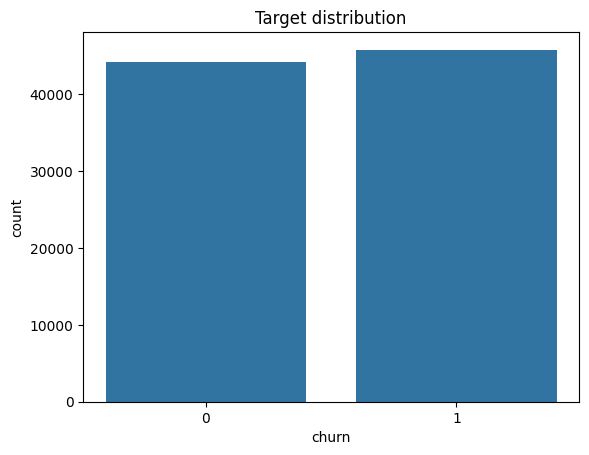

In [18]:
sns.countplot(data=df,x="churn")
plt.title('Target distribution')
plt.plot()

## Analisis Univariable

* Distribucion de cada variable

In [19]:
unicos(df,"O")

new_cell ['U' 'N' 'Y'] 

crclscod ['A' 'EA' 'C' 'B' 'BA' 'D' 'G' 'CA' 'I' 'AA' 'J' 'U' 'Z' 'K' 'E' 'E4' 'W'
 'DA' 'Y' 'CC' 'GA' 'D4' 'D5' 'H' 'ZA' 'JF' 'B2' 'IF' 'Z1' 'O' 'M' 'L'
 'U1' 'Z4' 'A2' 'V' 'TP' 'EM' 'C2' 'C5' 'S' 'EC' 'Z5' 'D2' 'GY' 'ZY' 'E2'
 'A3' 'V1' 'EF' 'Z2' 'CY' 'P1' 'ZF'] 

asl_flag ['N' 'Y'] 

prizm_social_one ['S' 'U' 'T' 'C' nan 'R'] 

area ['NORTHWEST/ROCKY MOUNTAIN AREA' 'CHICAGO AREA' 'GREAT LAKES AREA'
 'NEW ENGLAND AREA' 'DALLAS AREA' 'CENTRAL/SOUTH TEXAS AREA'
 'TENNESSEE AREA' 'MIDWEST AREA' 'PHILADELPHIA AREA' 'OHIO AREA'
 'HOUSTON AREA' 'SOUTHWEST AREA' 'NEW YORK CITY AREA'
 'ATLANTIC SOUTH AREA' 'SOUTH FLORIDA AREA' 'CALIFORNIA NORTH AREA'
 'DC/MARYLAND/VIRGINIA AREA' 'NORTH FLORIDA AREA' nan 'LOS ANGELES AREA'] 

dualband ['Y' 'N' 'T' 'U' nan] 

refurb_new ['N' 'R' nan] 

hnd_webcap ['WCMB' 'WC' nan 'UNKW'] 

ownrent ['O' nan 'R'] 

dwlltype ['S' 'M' nan] 

marital ['S' 'M' 'A' 'U' 'B' nan] 

infobase ['M' nan] 

HHstatin ['C' 'I' nan 'B' 'A' 'G' 'H'] 

d

In [20]:
#Value counts con nulos
#hnd_price redondear
#ASLflag a bin
#forgntvl,truck, rv a bool
valcounts(df,100)

drop_dat 
 0.000000      87782
0.333333        965
0.666667        438
1.000000        193
1.333333        146
1.666667         86
2.000000         64
2.333333         42
2.666667         36
3.333333         27
3.000000         27
4.000000         24
3.666667         19
4.333333         16
5.000000         14
5.333333         10
5.666667         10
6.000000          9
4.666667          9
9.333333          7
6.333333          7
7.333333          6
8.000000          5
8.333333          5
6.666667          5
10.000000         4
7.000000          4
9.666667          3
10.666667         3
11.000000         2
18.666667         2
12.000000         2
13.000000         2
9.000000          2
15.333333         1
15.000000         1
11.333333         1
8.666667          1
7.666667          1
20.666667         1
33.666667         1
14.000000         1
18.000000         1
20.000000         1
20.333333         1
25.333333         1
16.333333         1
21.333333         1
47.333333         1
12.333333

In [21]:
#hist(df)

In [22]:
for i in ["forgntvl","truck","rv"]:
    print(df[i].dtype.kind)
    print(df[i].value_counts(dropna=False))

f
0.0    83302
1.0     5247
NaN     1451
Name: forgntvl, dtype: int64
f
0.0    71088
1.0    17461
NaN     1451
Name: truck, dtype: int64
f
0.0    80857
1.0     7692
NaN     1451
Name: rv, dtype: int64


## Analisis Variable-Target

* Relacion target-variable

In [23]:
# dictt={}
# for i in df:
#     dft=(df[df["churn"]==1][i].value_counts()/df[i].value_counts()-df[df["churn"]==0][i].value_counts()/df[i].value_counts()).reset_index()
#     if df[i].dtype.kind =="O" and dft["count"].max()> 0.1:
#         dictt[i]=[dft.iloc[dft["count"].idxmax(),0],df[df["churn"]==1][i].value_counts().reset_index().iloc[dft["count"].idxmax(),1]]
# dictt        

In [24]:
# for i in dictt.keys():
#   # if df[i].dtype.kind =="O":
#       sns.countplot(x=i,hue="churn", data=df)  
#       plt.ylabel('Recuento')      
#       plt.tight_layout()  # Ajustar diseño para evitar superposiciones
#       plt.show()

In [25]:
# for i in numeric_columns:
#     sns.pairplot(df,x_vars="churn", y_vars=i)
#     plt.show()

In [26]:

df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
rev,89866.0,58.312895,46.084103,-5.862500,33.027500,47.667500,70.193750,3843.262500
mou,89866.0,504.277946,516.170057,0.000000,148.500000,349.000000,689.000000,12206.750000
totmrc,89866.0,45.880669,23.370435,-26.915000,30.000000,44.990000,59.990000,409.990000
da,89866.0,0.877813,2.173665,0.000000,0.000000,0.247500,0.742500,159.390000
ovrmou,89866.0,40.798976,96.970619,0.000000,0.000000,2.500000,41.250000,4320.750000
ovrrev,89866.0,13.289932,30.123282,0.000000,0.000000,0.900000,13.912500,1102.400000
vceovr,89866.0,13.046046,29.719581,0.000000,0.000000,0.600000,13.562500,896.087500
datovr,89866.0,0.240786,3.012631,0.000000,0.000000,0.000000,0.000000,423.540000
roam,89866.0,1.308197,15.374215,0.000000,0.000000,0.000000,0.257500,3685.200000
change_mou,89405.0,-13.786987,271.624916,-3875.000000,-85.750000,-6.500000,61.250000,31219.250000


In [27]:
df[df["rev"]<0]

,rev,mou,totmrc,da,ovrmou,ovrrev,vceovr,datovr,roam,change_mou,change_rev,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_vce,plcd_dat,recv_vce,recv_sms,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,mou_pead,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callfwdv,callwait,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays
Customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1052581,-2.5200,211.333333,0.483333,0.33,0.0,0.0,0.0,0.0,0.00,NaN,NaN,0.000000,0.0,0.0,0.0,7.333333,0.0,34.333333,0.0,2.666667,0.0,27.000000,0.0,1.333333,1.333333,0.093333,2.000000,0.000000,76.460000,0.0,1.693333,8.0,13.513333,1.333333,1.193333,12.666667,0.0,21.32,0.0,17.000000,0.0,56.833333,0.0,0.000000,34.333333,27.000000,0.0,0.0,0,18,2,2,U,BA,N,2181,11777.0,1179.17,1119.19,11563.0,2156,69.95,722.69,134.75,480,93,9,999.0,148.0,76.0,S,MIDWEST AREA,N,R,9.989998,2.0,2.0,WCMB,0.0,0.0,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN,NaN,NaN,0.0,G,U,U,U,U,U,N,281.0
1064115,-3.7300,103.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,NaN,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1,16,1,1,U,EA,Y,9177,20492.0,1423.92,1339.94,20440.0,9140,103.07,1572.31,703.08,1324,632,110,1536.0,749.0,103.0,S,MIDWEST AREA,Y,N,199.989990,2.0,2.0,WCMB,1.0,1.0,NaN,0.0,M,B,1.0,M,6.0,NaN,C,E,0.0,N,U,U,U,U,U,N,379.0
1066435,-5.8625,0.000000,-5.330000,0.00,0.0,0.0,0.0,0.0,0.00,0.0,5.8625,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0,15,3,3,U,BA,N,780,1338.0,405.81,345.83,1338.0,780,28.82,111.50,65.00,12,7,15,56.0,36.0,25.0,S,SOUTHWEST AREA,Y,N,59.989990,1.0,1.0,WCMB,0.0,0.0,O,9.0,S,M,1.0,M,6.0,NaN,B,A,0.0,S,U,U,U,U,U,N,452.0
1078619,-0.1600,214.000000,-9.030000,0.99,0.0,0.0,0.0,0.0,0.94,NaN,NaN,0.333333,0.0,0.0,0.0,14.666667,0.0,26.666667,0.0,12.666667,0.0,11.666667,0.0,0.666667,6.333333,5.943333,12.666667,0.333333,17.343333,0.0,0.173333,3.0,3.243333,0.000000,0.000000,9.000000,0.0,13.52,0.0,3.666667,0.0,3.996667,0.0,0.333333,26.666667,11.666667,0.0,0.0,1,7,2,2,U,EA,Y,1006,1761.0,294.31,258.62,1755.0,1004,64.66,438.75,251.00,400,225,50,NaN,NaN,NaN,S,DALLAS AREA,Y,N,149.989990,1.0,1.0,WCMB,0.0,0.0,O,9.0,S,M,3.0,M,8.0,1.0,I,A,0.0,N,U,U,U,Y,U,Y,214.0


In [28]:
df[df["totmrc"]<0]

,rev,mou,totmrc,da,ovrmou,ovrrev,vceovr,datovr,roam,change_mou,change_rev,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_vce,plcd_dat,recv_vce,recv_sms,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,mou_pead,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callfwdv,callwait,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays
Customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1007034,21.942500,328.75,-2.215000,0.0000,44.500000,17.7950,17.600,0.1950,6.5575,-328.75,-21.9425,4.333333,0.0,0.000000,0.0,3.666667,0.0,15.333333,0.000000,7.666667,0.0,7.666667,0.000000,0.666667,2.000000,1.483333,4.333333,0.000000,28.713333,0.000000,8.000000,1.666667,0.853333,0.000000,0.000000,1.000000,0.000000,3.513333,0.000000,10.333333,0.000000,33.200000,0.000000,4.333333,15.333333,7.666667,0.0,0.000000,0,33,1,1,Y,A,N,6049,23809.0,3890.68,3858.39,23789.0,6035,137.80,849.61,215.54,1632,259,221,1332.0,262.0,181.0,S,NEW ENGLAND AREA,Y,N,129.989990,4.0,2.0,WCMB,0.0,0.0,O,2.0,S,M,4.0,M,7.0,NaN,I,A,0.0,I,U,U,U,U,U,Y,596.0
1022622,49.300000,77.00,-0.240000,0.9900,44.500000,44.5000,44.500,0.0000,0.0000,-77.00,-44.3000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1,23,3,3,Y,AA,N,1428,2722.0,892.84,841.17,2722.0,1428,38.24,123.73,64.91,103,26,64,55.0,15.0,44.0,U,NEW YORK CITY AREA,Y,N,149.989990,3.0,2.0,WCMB,0.0,0.0,R,4.0,M,M,1.0,M,6.0,NaN,C,O,1.0,U,U,U,U,U,U,Y,324.0
1036074,19.933333,279.00,-1.613333,0.0000,89.666667,26.9000,26.900,0.0000,0.0000,NaN,NaN,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0,17,1,1,U,EA,N,5553,9097.0,1155.98,1099.53,8994.0,5514,78.54,642.43,393.86,949,486,121,718.0,394.0,91.0,U,LOS ANGELES AREA,Y,R,39.989990,3.0,2.0,WCMB,0.0,0.0,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N,U,U,U,U,U,N,290.0
1039872,45.810000,814.75,-0.282500,0.7425,108.750000,42.1000,42.100,0.0000,0.0000,90.25,27.0200,11.333333,0.0,1.000000,0.0,54.333333,0.0,211.333333,0.000000,80.666667,0.0,146.333333,0.000000,0.000000,0.000000,0.000000,59.000000,0.000000,465.400000,0.000000,192.923333,43.000000,81.290000,10.333333,57.633333,118.000000,0.000000,394.620000,0.000000,75.000000,0.000000,263.703333,0.000000,12.333333,211.333333,146.333333,0.0,1.333333,1,20,3,3,Y,BA,N,3146,11701.0,1323.26,1151.39,11127.0,2969,63.97,618.17,164.94,785,166,37,691.0,162.0,62.0,U,LOS ANGELES AREA,N,R,79.989990,4.0,3.0,WCMB,0.0,0.0,R,1.0,M,S,1.0,M,3.0,NaN,C,F,1.0,H,Y,U,Y,U,U,N,131.0
1041421,4.525000,136.75,-0.270000,0.4950,10.750000,4.3000,4.300,0.0000,0.0000,-6.75,11.8750,1.000000,0.0,0.000000,0.0,13.000000,0.0,76.666667,0.000000,11.000000,0.0,62.666667,0.000000,2.666667,4.000000,2.560000,8.333333,0.000000,59.116667,0.000000,9.236667,9.333333,5.733333,0.666667,1.190000,71.000000,0.000000,66.053333,0.000000,2.666667,0.000000,2.300000,0.000000,1.000000,76.666667,62.666667,0.0,0.000000,0,22,2,2,U,AA,N,1339,3220.0,623.83,588.20,3149.0,1331,29.41,157.45,66.55,139,81,1,130.0,75.0,17.0,T,MIDWEST AREA,Y,N,79.989990,1.0,1.0,WCMB,0.0,0.0,NaN,5.0,S,B,

In [29]:
df[df["avg6rev"]<0]

,rev,mou,totmrc,da,ovrmou,ovrrev,vceovr,datovr,roam,change_mou,change_rev,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_vce,plcd_dat,recv_vce,recv_sms,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,mou_pead,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callfwdv,callwait,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays
Customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1019096,5.0000,0.0,5.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1,25,1,1,U,CA,N,2288,6753.0,928.59,841.49,6457.0,2177,36.59,280.74,94.65,0,0,5,5.0,3.0,-1.0,C,NEW ENGLAND AREA,N,N,79.98999,1.0,1.0,WC,0.0,0.0,O,NaN,NaN,S,1.0,M,7.0,NaN,A,NaN,0.0,N,U,U,U,U,U,Y,751.0
1049742,29.8325,190.5,29.8325,0.0,0.0,0.0,0.0,0.0,0.0,571.5,74.4975,2.0,0.0,0.333333,0.0,2.0,0.0,7.333333,0.0,2.333333,0.0,3.666667,0.0,0.333333,0.333333,0.226667,0.0,0.0,47.743333,0.0,4.92,0.333333,1.323333,0.0,0.0,2.666667,0.0,7.396667,0.0,2.666667,0.0,45.266667,0.0,2.333333,7.333333,3.666667,0.0,0.0,0,17,1,1,U,AA,N,658,4495.0,657.59,577.61,4494.0,657,36.10,280.88,41.06,0,0,5,0.0,0.0,-1.0,NaN,NEW YORK CITY AREA,Y,N,59.98999,1.0,1.0,WCMB,0.0,0.0,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N,U,U,U,U,U,N,502.0
1061910,5.0000,0.0,5.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1,12,1,1,U,BA,N,413,2233.0,329.27,269.29,2226.0,412,24.48,202.36,37.45,0,0,5,10.0,3.0,-2.0,NaN,NORTH FLORIDA AREA,Y,N,59.98999,1.0,1.0,WCMB,0.0,0.0,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN,NaN,NaN,0.0,S,U,U,U,U,U,N,371.0


# Data Cleaning

* Eliminar filas sin target informado.
* Eliminar filas duplicadas (si tenemos ID, solo puede haber 1 registro por ID)
* Eliminar filas/columnas vacías y columnas irrelevantes
* Corregir data types incorrectos
* Categoricos: Corregir literales incorrectos (acentos, erratas, etc)
* Fechas y textos: convertir a variables numericas (hour, day, month, year...) o categoricas (weekday_name...)

In [30]:
df["churn"].unique()

array([1, 0], dtype=int64)

In [31]:
df["churn"].isnull().sum()

0

In [32]:
df[df.duplicated(keep=False)]

,rev,mou,totmrc,da,ovrmou,ovrrev,vceovr,datovr,roam,change_mou,change_rev,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_vce,plcd_dat,recv_vce,recv_sms,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,mou_pead,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callfwdv,callwait,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays
Customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [33]:
for i in columnas_menos_relevantes:
    del(df[i])

In [34]:
x=[45000]#,55000,65000,75000,85000]
ceros=[]
dict={}
for j in x:
    ceros=[]
    for i in df:
        if df[i].dtype.kind in ("f","i") and len(df[i].unique())>3:
            if df[i].value_counts().reset_index().iloc[0,1]>j and int(df[i].value_counts().reset_index().iloc[0,0])==0:
             ceros.append(i)
    dict[j]=len(ceros) 
dict    

{45000: 19}

In [35]:
for i in ceros:
        df[i]=np.where(df[i]>0,1,np.where(df[i]==0,0,df[i]))

In [37]:
df["hnd_price"]=df["hnd_price"].round(decimals=0)

In [38]:
df["hnd_price"].dtype.kind

'f'

In [39]:
#ASLflag a bin
#forgntvl,truck, rv a bool

In [40]:
df["asl_flag"].replace({"Y":1,"N":0},inplace=True)


In [41]:
df["hnd_webcap"].replace({"UNKW":"U"},inplace=True)

In [42]:
for i in ["forgntvl","truck","rv"]:
    df[i].replace({1:"Y",0:"N"},inplace=True)
    #df[i]=df[i].fillna("U")
    

In [43]:
for i in ["forgntvl","truck","rv"]:
    #df[i]=df[i].astype(str)
    print(df[i].dtype.kind)

O
O
O


In [ ]:
df.describe().T

In [44]:
for i in df:
    if df[i].dtype.kind =="f" and np.modf(df[i])[0].sum()==0 and df[i].isnull().sum()==0:
       df[i].astype(int) 

In [45]:
kids=['kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17']

In [46]:
for i in kids:
    df[i].replace({"Y":1,"U":0},inplace=True)

In [47]:
df["kids_suma"]=df[kids].sum(axis=1)

In [48]:
df["kids_suma"].value_counts()

0.0    68766
1.0    12279
2.0     6988
3.0     1749
4.0      205
5.0       13
Name: kids_suma, dtype: int64

In [49]:
for i in kids:
    del(df[i])

# Imputación de nulos

* MODELOS DE ARBOLES: Imputar valor outlier. 
* MODELOS LINEALES: imputar media, mediana o moda.
* Si vamos a practicar un Torneo de Modelos, preferible imputar valor outlier.

In [ ]:
df.describe(include=[np.number]).T

In [ ]:
df.isnull().sum()[df.isnull().sum() > 0]

In [50]:
for i in df:
    if df[i].dtype.kind=="O":
        df[i]=df[i].replace({np.nan:"U"})
    elif df[i].dtype.kind in ["f","i"]:  
        df[i].fillna(-99999,inplace= True)


In [51]:
#corregimos dtypes posterior a la imputacion de nulos
for i in df:
    if df[i].dtype.kind =="f" and np.modf(df[i])[0].sum()==0:
       df[i].astype(int) 
            

# Encoding categóricos

* Si tienen sentido ordinal, es decir, se pueden ordenar, encodear con una escala numerica. Ejemplo: {"Bajo":1, "Medio":2, "Alto":3}.
* Si tienen unicamente 2 clases, indicador booleano
* One Hot Encoding en resto de categoricos

In [52]:
orden=df["crclscod"].value_counts().reset_index()["index"].to_list()
orden.reverse()
mapeo_categorias = {categoria: indice for indice, categoria in enumerate(orden)}

In [53]:
OE=OrdinalEncoder(categories=[orden])
df["crclscod"]=OE.fit_transform(df[["crclscod"]])

In [54]:
# separamos nuestro dataset entre columnas numericas y object

numeric_columns = df.select_dtypes(include = np.number).columns.tolist()
object_columns = df.select_dtypes(exclude = np.number).columns.tolist()

assert (len(numeric_columns) + len(object_columns)) == df.shape[1], "You have missed some columns"

In [55]:
df=pd.get_dummies(data=df ,columns=object_columns,dtype=int)

In [ ]:
# CTCat=ColumnTransformer(transformers=
#                         [("OHE",OneHotEncoder(sparse_output=False),object_columns)],
#                         remainder = "passthrough")

In [ ]:
# df=CTCat.fit_transform(df)

In [56]:
df.head()

,rev,mou,totmrc,da,ovrmou,ovrrev,vceovr,datovr,roam,change_mou,change_rev,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_vce,plcd_dat,recv_vce,recv_sms,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,mou_pead,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callfwdv,callwait,churn,months,uniqsubs,actvsubs,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,hnd_price,phones,models,income,eqpdays,kids_suma,refurb_new_N,refurb_new_R,refurb_new_U,hnd_webcap_U,hnd_webcap_WC,hnd_webcap_WCMB,truck_N,truck_U,truck_Y,rv_N,rv_U,rv_Y,forgntvl_N,forgntvl_U,forgntvl_Y,creditcd_N,creditcd_U,creditcd_Y
Customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.0,0.0,0.0,18.000000,0.0,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,1.0,1,61,2,1,52.0,0,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,150.0,2.0,2.0,4.0,361.0,0.0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1
1000002,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.0,1.0,1.0,53.000000,1.0,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,1.0,0,56,1,1,49.0,0,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,-99999.0,7.0,6.0,5.0,240.0,0.0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1
1000003,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.0,0.0,0.0,0.333333,0.0,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.0,1,58,1,1,45.0,0,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,30.0,2.0,1.0,5.0,1504.0,1.0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
1000004,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.0,0.0,0.0,1.333333,0.0,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,0.0,5.450000,0.0,0.000000,3.666667,3.666667,0.0,0.0,0,60,1,1,48.0,0,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,30.0,1.0,1.0,6.0,1812.0,1.0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
1000005,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,1.0,1.0,1.0,66.000000,0.0,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.0,0,57,1,1,52.0,0,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,150.0,6.0,4.0,6.0,434.0,0.0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1


In [57]:
df.shape

(90000, 93)

In [ ]:
df.describe(include=[np.number]).T

# Eliminar alta correlación

* Analizar variables (X) altamente correlacionadas
* Eliminar una variable de cada pareja altamente correlacionada (>95% o >99%...) en el dataset (df)

In [58]:
# separamos nuestro dataset entre columnas numericas y object

numeric_columns2 = df.select_dtypes(include = np.number).columns.tolist()
object_columns2 = df.select_dtypes(exclude = np.number).columns.tolist()

assert (len(numeric_columns2) + len(object_columns2)) == df.shape[1], "You have missed some columns"

In [59]:
numeric_columns2.remove('churn')

In [60]:
highly_corr = highly_correlated(df[numeric_columns2],df['churn'],0.95)
highly_corr

C:\Users\rstee\AppData\Local\Temp\ipykernel_15484\3316001217.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['F_to_delete'][Z['corr_F1_target'] < Z['corr_F2_target']] = Z['F1'][Z['corr_F1_target'] < Z['corr_F2_target']]


,F1,F2,corr_F1_F2,corr_F1_target,corr_F2_target,F_to_delete
0,mou,rev,0.992300,0.041246,0.034069,rev
1,totmrc,rev,0.999954,0.034306,0.034069,rev
2,totmrc,mou,0.991701,0.034306,0.041246,totmrc
3,da,rev,0.999931,0.033909,0.034069,da
4,da,mou,0.991287,0.033909,0.041246,da
5,da,totmrc,0.999983,0.033909,0.034306,da
6,ovrmou,rev,0.999844,0.033479,0.034069,ovrmou
7,ovrmou,mou,0.992859,0.033479,0.041246,ovrmou
8,ovrmou,totmrc,0.999697,0.033479,0.034306,ovrmou
9,ovrmou,da,0.999689,0.033479,0.033909,ovrmou


In [61]:
for i in highly_corr["F_to_delete"].unique().tolist():
    del(df[i])

# Eliminar baja varianza

* Eliminar variables (X) practicamente constantes con un threshold minimo (1% o menos)

In [62]:
vt = VarianceThreshold(threshold = 0.01)
vt.fit(df)

cols_lowvar = df.columns[vt.get_support()==False]
cols_lowvar

Index(['recv_sms', 'callfwdv', 'refurb_new_U'], dtype='object')

In [63]:
for i in cols_lowvar:
    del(df[i])

In [64]:
df.shape

(90000, 59)

# Guardar clean data

* Guardar en data path y mostrar el resultado en un head()

In [65]:
from pathlib import Path  
filepath = Path("data/TT_churn_clean.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath,index=True) 

In [66]:
df.head(5)

,mou,change_mou,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_dat,recv_vce,cc_mou,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,opk_vce,opk_dat,mou_opkv,drop_blk,complete,callwait,churn,months,uniqsubs,actvsubs,crclscod,asl_flag,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6rev,hnd_price,income,eqpdays,kids_suma,refurb_new_R,hnd_webcap_U,hnd_webcap_WC,hnd_webcap_WCMB,truck_N,rv_N,rv_Y,forgntvl_N,forgntvl_Y,creditcd_N,creditcd_U
Customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,219.25,-157.25,0.666667,0.0,0.666667,0.0,6.333333,0.0,0.0,42.333333,0.0,0.0,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,24.000000,0.0,55.220000,1.333333,45.000000,1.0,1,61,2,1,52.0,0,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,38.0,150.0,4.0,361.0,0.0,0,0,0,1,1,1,0,1,0,0,0
1000002,482.75,532.25,8.333333,0.0,1.000000,0.0,61.333333,0.0,0.0,69.000000,1.0,1.0,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,157.000000,0.0,169.343333,9.333333,193.333333,1.0,0,56,1,1,49.0,0,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,48.0,-99999.0,5.0,240.0,0.0,0,0,1,0,0,0,1,1,0,0,0
1000003,10.25,-4.25,0.333333,0.0,0.000000,0.0,2.666667,0.0,0.0,0.333333,0.0,0.0,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,1.000000,0.0,0.233333,0.333333,6.000000,0.0,1,58,1,1,45.0,0,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,17.0,30.0,5.0,1504.0,1.0,0,1,0,0,1,1,0,1,0,0,0
1000004,7.50,-1.50,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.333333,0.0,0.0,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,3.666667,0.0,5.450000,0.000000,3.666667,0.0,0,60,1,1,48.0,0,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,40.0,30.0,6.0,1812.0,1.0,0,1,0,0,1,1,0,1,0,0,0
1000005,570.50,38.50,9.666667,0.0,0.666667,0.0,77.000000,0.0,0.0,94.666667,1.0,0.0,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,90.333333,0.0,218.086667,10.333333,137.000000,0.0,0,57,1,1,52.0,0,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,80.0,150.0,6.0,434.0,0.0,0,0,0,1,1,1,0,1,0,0,0


tratar negativos como outliers